In [1]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [2]:
# Path ke dataset
train_dir = r'D:\Ara\bougainville\training'
val_dir = r'D:\Ara\bougainville\validation'

In [4]:
# Augmentasi data dengan validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Tambahkan validation split
)

# Gunakan subset 'training' untuk train_generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Gunakan subset 'validation' untuk val_generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 320 images belonging to 5 classes.


Found 80 images belonging to 5 classes.


In [5]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),  # Penambahan dropout ringan di awal

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(train_generator.num_classes, activation='softmax')
])

d:\Ara\Web\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Load base model
base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze layer awal

# Tambahkan classifier di atasnya
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1
)


C:\Users\pondo\AppData\Local\Temp\ipykernel_19068\3221355014.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
d:\Ara\Web\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 597ms/step - accuracy: 0.1400 - loss: 2.4061 - val_accuracy: 0.2000 - val_loss: 1.7449
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.2283 - loss: 2.0403 - val_accuracy: 0.4000 - val_loss: 1.5862
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step - accuracy: 0.3659 - loss: 1.6518 - val_accuracy: 0.4625 - val_loss: 1.3303
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.4193 - loss: 1.5186 - val_accuracy: 0.5500 - val_loss: 1.2321
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - accuracy: 0.4592 - loss: 1.3445 - val_accuracy: 0.6125 - val_loss: 1.0818
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.5374 - loss: 1.2765 - val_accuracy: 0.5750 - val_loss: 0.9804
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - accuracy: 0.5390 - loss: 1.1527 - val_accuracy: 0.7000 - val_loss: 0.8959
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - accuracy: 0.5309 - loss: 1.0976 - val_accuracy: 0.

In [9]:
# Menyimpan model
model.save('model_bougainville.keras')

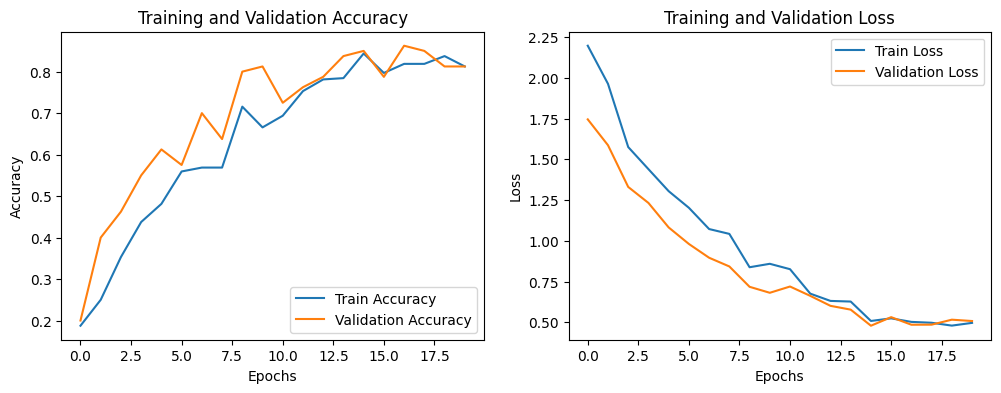

In [7]:
# Plot grafik akurasi dan loss
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [8]:
# Evaluasi model dan classification report
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys(), zero_division=1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step
Classification Report:
              precision    recall  f1-score   support

   afterglow       0.06      0.06      0.06        16
  coconutice       0.13      0.12      0.13        16
      glabra       0.18      0.19      0.18        16
    goldrush       0.13      0.12      0.13        16
 spectabilis       0.12      0.12      0.12        16

    accuracy                           0.12        80
   macro avg       0.13      0.12      0.13        80
weighted avg       0.13      0.12      0.13        80

